In [1]:
import pandas as pd
from typing import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

pd.set_option('display.max_columns', None)

# Aggregate NSPIRE
The goal of this notebook is to aggregate NSPIRE demo data at the locality level (city, town, village, etc.)

In [2]:
nspire = pd.read_csv('../data/nspire_demo_deficiencies.csv',
                     low_memory=False)

In [3]:
nspire

,Unit,NSPIRE Health & Safety,Deficiency Details,Question Template: Question Template ID,Inspection ID,Deficiency ID,Room/Location,Mitigation Details,Mitigation Reviewer Comment,Mitigation Late (Y/N),Location (Unit/Inside/Outside),Reviewer Comment,Reviewer Finding(s),Room,Unit Address,Status,Inspector: Full Name,Inspectable Area,H&S Determination (LT-24hr / Std 30 Day),Deficiency Location Address,Date/Time Mitigated,Deficiency Reviewed By: Full Name,Mitigation Date (PHA/POA Input),Deficiency Comments,PropertyId,NSPIRE Standards,Defect Recorded Date/Time,Date/Time Mitigation Reviewed,Date/Time Mitigation Submitted,Field Office Acknowledge (Date),Description of Repair (PHA/POA input),Corrective Timeframe,Codes,Defect Recorded Date,Shipping Address,Shipping City,Shipping Street,Shipping State/Province,Shipping Zip/Postal Code
0,THE TOWERS APARTMENTS,Severe Non-Life-Threatening,Inside -> Exit Sign -> Lighted exit sign does ...,Q-86826,INSP-01563,QR-5715325,Halls/Corridors/Stairs,Exit sign fixed,Photo submitted of mitigation. The light is on...,NaN,Inside,NaN,NaN,NaN,NaN,Mitigation Approved,NaN,Inside,Severe Non-Life-Threatening 24 hours,"913 NW 12th Street Oklahoma City, OK 73106",8/10/2022 12:30 PM,Zachary Dobelbower,NaN,Needs a battery 4th floor,0013d000008bJ27,Exit Sign,8/9/2022 7:09 PM,10/25/2022 12:07 PM,8/10/2022 10:35 AM,NaN,NaN,24 hours,"r1, r2, m2, m3",8/9/2022,"117 NW 9, OKLAHOMA CITY, OK 73102",OKLAHOMA CITY,117 NW 9,OK,73102
1,MORNINGSIDE HEIGHTS,Standard,Unit -> Windows -> Window cannot be secured ->...,Q-86231,INSP-00310,QR-4394075,Bedroom 1,NaN,NaN,NaN,Unit,NaN,NaN,NaN,UNIT: G,Acknowledged/Unmitigated,NaN,Unit,Standard 30 days,7,NaN,NaN,NaN,Damaged lock,001t000000poMNP,Windows,1/5/2022 3:25 PM,NaN,NaN,NaN,NaN,30 days,"r4, r6, m1",1/5/2022,"1516 East 6th Street, La Junta, CO 81050 Unite...",La Junta,1516 East 6th Street,CO,81050
2,CHESTNUT COURT,Standard,Unit -> Bathtub and Shower -> Bathtub componen...,Q-85787,INSP-00567,QR-4569630,Bathroom 1,NaN,NaN,NaN,Unit,NaN,NaN,NaN,352318,Acknowledged/Unmitigated,NaN,Unit,Standard 30 days,NaN,NaN,NaN,NaN,Shower not operational 2318,0013d000005B3Sr,Bathtub and Shower,3/10/2022 3:22 PM,NaN,NaN,NaN,NaN,30 days,"r3, r6, m1",3/10/2022,"Chestnut Street, Oakland, CA 94607",Oakland,Chestnut Street,CA,94607
3,MHPI VII,Standard,Unit -> Leak -> Plumbing leaks -> Failure of a...,Q-86168,INSP-00893,QR-4959929,Bathroom 1,NaN,NaN,NaN,Unit,NaN,NaN,NaN,UNIT 12: 206,Acknowledged/Unmitigated,NaN,Unit,Standard 30 days,206,NaN,NaN,NaN,Water leaking under bathroom sink,0013d000007M822,Leak,5/5/2022 9:01 PM,NaN,NaN,NaN,NaN,30 days,"r1, r2, r3, r6, m1, m4, m6",5/5/2022,"333 Market Street, Boston, MA 02135 United States",Boston,333 Market Street,MA,02135
4,VISTA VILLA,Life-Threatening,Unit -> Smoke Alarm -> Smoke alarm is not inst...,Q-86190,INSP-00993,QR-5076835,Living Room,Completed work order,NaN,NaN,Unit,NaN,NaN,NaN,13,Evidence of Mitigation Submitted,NaN,Unit,Life-Threatening 24 hours,13,5/20/2022 7:36 AM,NaN,NaN,Smoke detector missing in living room.,0013d000007SKDf,Smoke Alarm,5/18/2022 8:35 PM,NaN,7/6/2022 7:36 AM,NaN,NaN,24 hours,"r2, m2",5/18/2022,"3600 Pansy Street, Pasadena, TX 77505 United S...",Pasadena,3600 Pansy Street,TX,77505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77315,TROUBLESOME VAL-PIPPA PA,NaN,NaN,NaN,INSP-00992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"997 Kentucky 160, Hindman, KY 41822 United States",Hindman,997 Kentucky 160,KY,41822
77316,COLONEL HAMTRAMCK HOMES,NaN,NaN,NaN,INSP-03325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"12025 Dequindre Street, Hamtramck, MI 48212 Un...",Hamtramck,12025 Dequindre Street,MI,48212
77317,GRACES WAY,NaN,NaN,NaN,INSP-01296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Basic cleaning

In [21]:
nspire.loc[:, nspire.columns[:20]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77320 entries, 0 to 77319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unit                                      77320 non-null  object 
 1   NSPIRE Health & Safety                    66820 non-null  object 
 2   Deficiency Details                        77248 non-null  object 
 3   Question Template: Question Template ID   77248 non-null  object 
 4   Inspection ID                             77320 non-null  object 
 5   Deficiency ID                             77248 non-null  object 
 6   Room/Location                             77185 non-null  object 
 7   Mitigation Details                        32461 non-null  object 
 8   Mitigation Reviewer Comment               3420 non-null   object 
 9   Mitigation Late (Y/N)                     0 non-null      float64
 10  Location (Unit/Inside/Outside)    

In [22]:
nspire.loc[:, nspire.columns[20:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77320 entries, 0 to 77319
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date/Time Mitigated                    32461 non-null  object 
 1   Deficiency Reviewed By: Full Name      4536 non-null   object 
 2   Mitigation Date (PHA/POA Input)        0 non-null      float64
 3   Deficiency Comments                    77220 non-null  object 
 4   PropertyId                             77248 non-null  object 
 5   NSPIRE Standards                       77248 non-null  object 
 6   Defect Recorded Date/Time              77248 non-null  object 
 7   Date/Time Mitigation Reviewed          4536 non-null   object 
 8   Date/Time Mitigation Submitted         32461 non-null  object 
 9   Field Office Acknowledge (Date)        0 non-null      float64
 10  Description of Repair (PHA/POA input)  0 non-null      float64
 11  Co

Split deficiency details into separate columns.

In [23]:
def split_by_arrow(string: str) -> List[str]:
    if pd.isna(string):
        return [np.nan, np.nan, np.nan]  # Return a list of NaNs if the string is NaN
    else:
        split_string = string.split('->')
        # If there are less than 3 substrings, prepend the list with NaNs
        while len(split_string) < 4:
            split_string.insert(0, np.nan)
        return split_string

nspire_details = nspire['Deficiency Details'].apply(split_by_arrow).apply(pd.Series)
nspire_details = nspire_details.rename(columns = {0: 'details1', 1: 'details2', 2: 'details3', 3: 'details4'})
nspire = pd.concat([nspire, nspire_details], axis=1)

Standardize and remove bad state name values.

In [24]:
nspire['Shipping State/Province'].unique()

array(['OK', 'CO', 'CA', 'MA', 'TX', 'LA', 'KY', 'IL', 'TN', 'NC', 'MD',
       'AL', 'CT', 'PA', 'UT', 'MO', 'NE', 'NY', 'SC', 'MS', 'FL', 'RI',
       nan, 'GA', 'IN', 'WA', 'DE', 'AR', 'NJ', 'MI', 'NH', 'NV', 'WI',
       'VA', 'AZ', 'VT', 'OH', 'MN', 'KS', 'What is your favorite movie?',
       'SD', 'ME', 'ON', 'WV', 'pa', 'IA', 'OR', 'MT', 'NM', 'ND'],
      dtype=object)

In [25]:
nspire['Shipping State/Province'] = nspire['Shipping State/Province'].str.upper()

In [26]:
print(len(nspire))

nspire = nspire[nspire['Shipping State/Province'].apply(
    lambda x: True if pd.isna(x) or len(str(x)) <= 2 else False
)]

print(len(nspire))

77320
77307


In [27]:
nspire['Shipping City'] = nspire['Shipping City'].str.upper()

# Looking at structure of the dataset

It seems that the dataset has one row for every deficiency identified. Let's verify this.

In [28]:
inspections = nspire.groupby('Inspection ID').size()
inspections.sort_values()

Inspection ID
INSP-00108      1
INSP-01928      1
INSP-01096      1
INSP-01927      1
INSP-01924      1
             ... 
INSP-03032    169
INSP-02613    170
INSP-01165    182
INSP-03067    187
INSP-03079    200
Length: 2993, dtype: int64

Each inspection has various amounts of deficiencies that were discovered.

In [29]:
inspections.describe()

count    2993.000000
mean       25.829268
std        26.552036
min         1.000000
25%         7.000000
50%        17.000000
75%        35.000000
max       200.000000
dtype: float64

Here's an example of one inspection with multiple deficiency found and mitigated.

In [30]:
# nspire[nspire['Date/Time Mitigated'].notna()]
nspire[nspire.Unit == 'THE TOWERS APARTMENTS']

,Unit,NSPIRE Health & Safety,Deficiency Details,Question Template: Question Template ID,Inspection ID,Deficiency ID,Room/Location,Mitigation Details,Mitigation Reviewer Comment,Mitigation Late (Y/N),Location (Unit/Inside/Outside),Reviewer Comment,Reviewer Finding(s),Room,Unit Address,Status,Inspector: Full Name,Inspectable Area,H&S Determination (LT-24hr / Std 30 Day),Deficiency Location Address,Date/Time Mitigated,Deficiency Reviewed By: Full Name,Mitigation Date (PHA/POA Input),Deficiency Comments,PropertyId,NSPIRE Standards,Defect Recorded Date/Time,Date/Time Mitigation Reviewed,Date/Time Mitigation Submitted,Field Office Acknowledge (Date),Description of Repair (PHA/POA input),Corrective Timeframe,Codes,Defect Recorded Date,Shipping Address,Shipping City,Shipping Street,Shipping State/Province,Shipping Zip/Postal Code,details1,details2,details3,details4
0,THE TOWERS APARTMENTS,Severe Non-Life-Threatening,Inside -> Exit Sign -> Lighted exit sign does ...,Q-86826,INSP-01563,QR-5715325,Halls/Corridors/Stairs,Exit sign fixed,Photo submitted of mitigation. The light is on...,NaN,Inside,NaN,NaN,NaN,NaN,Mitigation Approved,NaN,Inside,Severe Non-Life-Threatening 24 hours,"913 NW 12th Street Oklahoma City, OK 73106",8/10/2022 12:30 PM,Zachary Dobelbower,NaN,Needs a battery 4th floor,0013d000008bJ27,Exit Sign,8/9/2022 7:09 PM,10/25/2022 12:07 PM,8/10/2022 10:35 AM,NaN,NaN,24 hours,"r1, r2, m2, m3",8/9/2022,"117 NW 9, OKLAHOMA CITY, OK 73102",OKLAHOMA CITY,117 NW 9,OK,73102,Inside,Exit Sign,Lighted exit sign does not illuminate or ther...,Exit sign does not illuminate.
16,THE TOWERS APARTMENTS,Standard,Inside -> Handrail -> Handrail is not secure -...,Q-86898,INSP-01563,QR-5715772,Halls/Corridors/Stairs,Tighten hand rail;Work Completed.,NaN,NaN,Inside,NaN,NaN,NaN,NaN,Evidence of Mitigation Submitted,NaN,Inside,Standard 30 days,"125 NW 9th Street Oklahoma City, OK 73102",8/11/2022 12:00 PM,NaN,NaN,Loose on East tower 2nd floor,0013d000008bJ27,Handrail,8/9/2022 7:10 PM,NaN,8/29/2022 2:45 PM,NaN,NaN,30 days,"r2, m1, m2",8/9/2022,"117 NW 9, OKLAHOMA CITY, OK 73102",OKLAHOMA CITY,117 NW 9,OK,73102,Inside,Handrail,Handrail is not secure,There is movement in the anchors of the handr...
32,THE TOWERS APARTMENTS,Standard,Inside -> Floor Covering and Finish -> Floor c...,Q-86848,INSP-01563,QR-5715780,Halls/Corridors/Stairs,Requested Tech Service Dept. to secure floorin...,NaN,NaN,Inside,NaN,NaN,NaN,NaN,Evidence of Mitigation Submitted,NaN,Inside,Standard 30 days,"125 NW 9th Street Oklahoma City, OK 73102",8/15/2022 4:00 PM,NaN,NaN,2nd floor by unit 27a,0013d000008bJ27,Floor Covering and Finish,8/9/2022 7:10 PM,NaN,9/2/2022 7:21 AM,NaN,NaN,30 days,"r2, m1, m2, m4",8/9/2022,"117 NW 9, OKLAHOMA CITY, OK 73102",OKLAHOMA CITY,117 NW 9,OK,73102,Inside,Floor Covering and Finish,"Floor covering is curling, buckling, bulging,...","Any portion of the floor covering is curling,..."
48,THE TOWERS APARTMENTS,Standard,Inside -> Ceiling -> Ceiling has an unstable s...,Q-86624,INSP-01563,QR-5715784,Lobby,Tore out oils Sheetrock and replaced with new....,NaN,NaN,Inside,NaN,NaN,NaN,NaN,Evidence of Mitigation Submitted,NaN,Inside,Standard 30 days,"125 NW 9th Street Oklahoma City, OK 73102",8/18/2022 12:30 PM,NaN,NaN,Unstable due to prior leak in west tower,0013d000008bJ27,Ceiling,8/9/2022 7:10 PM,NaN,9/5/2022 8:03 PM,NaN,NaN,30 days,"r2, r6, m1",8/9/2022,"117 NW 9, OKLAHOMA CITY, OK 73102",OKLAHOMA CITY,117 NW 9,OK,73102,Inside,Ceiling,Ceiling has an unstable surface,Ceiling has an unstable surface
64,THE TOWERS APARTMENTS,Standard,Inside -> Floor Covering and Finish -> Floor s...,Q-86844,INSP-01563,QR-5715788,Halls/Corridors/Stairs,Floor tile completed by contractor;Work Comple...,NaN,NaN,Inside,NaN,NaN,NaN,NaN,Evidence of Mitigation Submitted,NaN,Inside,Standard 30 days,"125 NW 9th Street Oklahoma City, OK 73102",8/15/2022 4:30 PM,NaN,NaN,Due to electrical issue in unit 105 west tower,0013d000008bJ27,Floor Covering and Finish,8/9/2022 7:10 PM,NaN,9/2/2022 7:25

# Time breakdown

Look at times when deficiencies were identified.

In [31]:
# Cast to datetime
nspire['Defect Recorded Date'] = pd.to_datetime(nspire['Defect Recorded Date'])

# Create new columns for year and month
nspire['Defect Recorded Year'] = nspire['Defect Recorded Date'].dt.year
nspire['Defect Recorded Month'] = nspire['Defect Recorded Date'].dt.month

In [32]:
nspire.groupby(['Defect Recorded Year']).nunique()['Inspection ID']


Defect Recorded Year
2021.0      21
2022.0    2353
2023.0     548
Name: Inspection ID, dtype: int64

# How many deficiencies are fire related?

In [33]:
fire_standards = [
    "Carbon Monoxide Alarm",
    "Leak",
    "Chimney",
    "Door - Fire Labeled",
    "Electrical - Outlet and Switch",
    "Electrical - Conductor",
    "Electrical - Service Panel",
    "Electrical - GFCI or AFCI Outlet or Breaker",
    "Fire Escape",
    "Fire Extinguisher",
    "Flammable and Combustible Item",
    "Smoke Alarm",
    "Heating, Ventilation, and Air Conditioning (HVAC)",
    "Kitchen Ventilation",
    "Structural System"
]


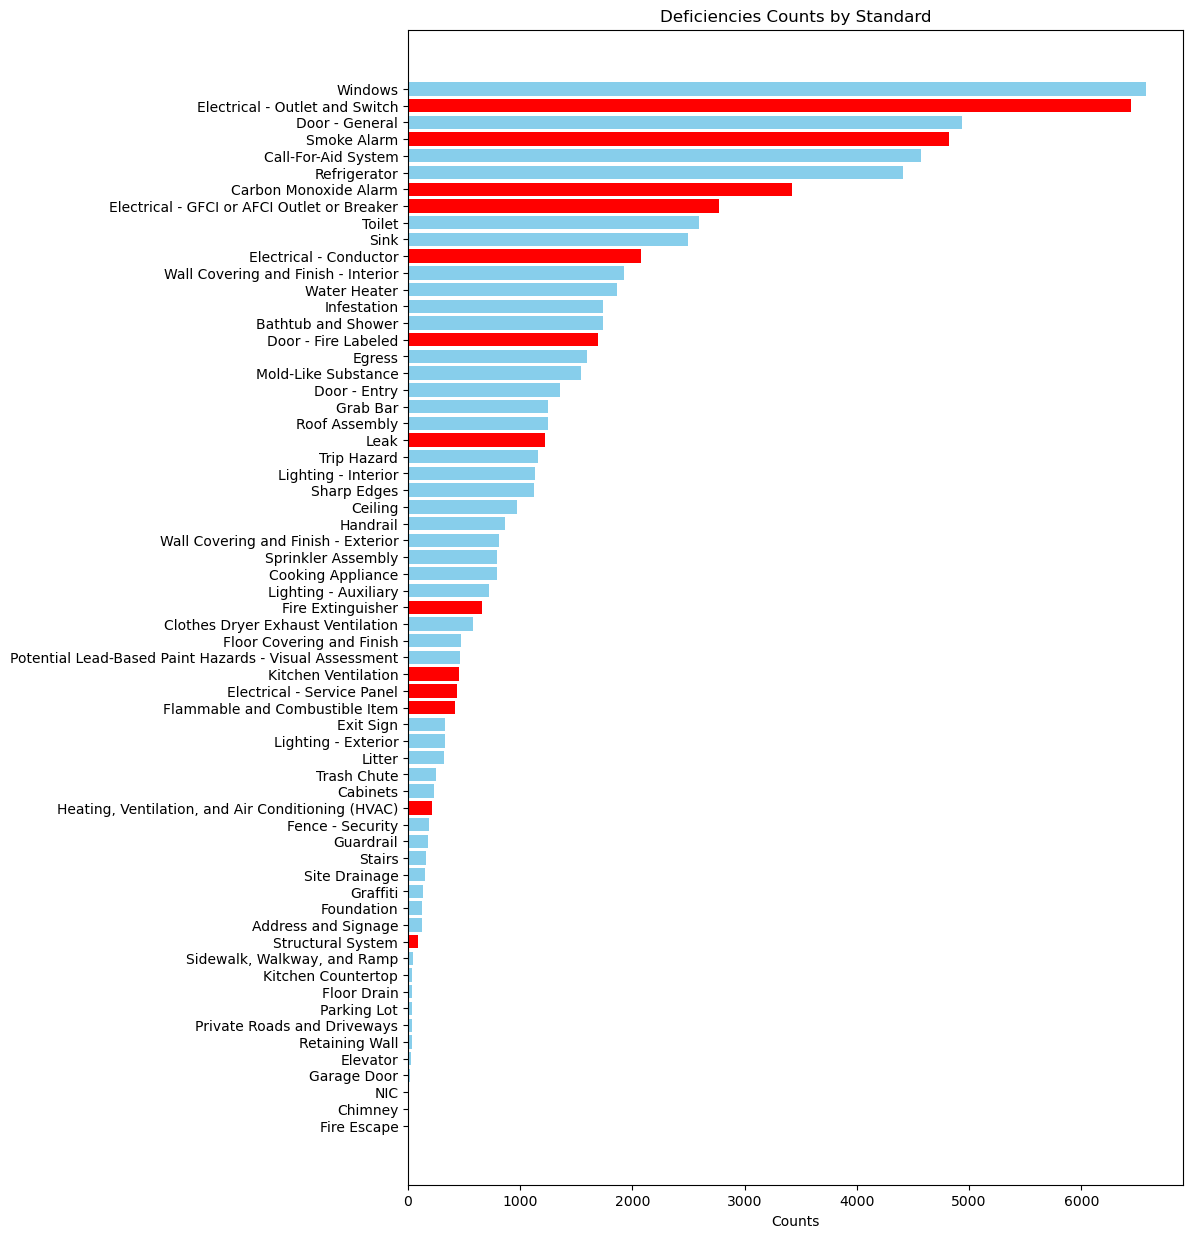

In [34]:
data = nspire.groupby('NSPIRE Standards').size().sort_values()

# Extract labels and values
labels = data.index.tolist()
values = data.values.tolist()

# Determine the color of each bar
colors = ['skyblue' if label.strip() not in fire_standards else 'red' for label in labels]

# Create the bar plot
plt.figure(figsize=(10, 15))
plt.barh(labels, values, color=colors)
plt.xlabel('Counts')
plt.title('Deficiencies Counts by Standard')
plt.show()

# Characteristics of fire-related deficiencies

In [35]:
nspire_notna = nspire[nspire['NSPIRE Standards'].notna()]

In [36]:
fire_related = nspire_notna[nspire_notna['NSPIRE Standards'].isin(fire_standards)]

In [37]:
for standard in fire_related['NSPIRE Standards'].unique():
    details3_counts = fire_related[fire_related['NSPIRE Standards'] == standard]['details3'].value_counts()
    
    # Print the standard in bold
    display(standard)
    
    # Print each unique 'details3' with its count as a bullet point
    for detail, count in details3_counts.items():
        display(Markdown(f"- {detail}: {count} occurrences"))
        
    # Add a line break for readability
    display(Markdown("---"))


'Leak'

-  Plumbing leaks : 998 occurrences

-  Environmental water intrusion : 124 occurrences

-  Leak in sewage system : 41 occurrences

-  Cap to the cleanout is detached or missing : 28 occurrences

-  Cleanout cap or riser has penetrative hole or crack : 16 occurrences

-  Blocked sewage system : 8 occurrences

-  Natural gas, propane, or oil leak : 7 occurrences

---

'Smoke Alarm'

-  Smoke alarm is not installed where required : 3466 occurrences

-  Smoke alarm does not produce an audio or visual alarm when tested : 1352 occurrences

---

'Flammable and Combustible Item'

-  Improperly stored flammable or combustible item on or near an ignition source : 421 occurrences

---

'Electrical - GFCI or AFCI Outlet or Breaker'

-  GFCI outlet or GFCI breaker is not visibly damaged and the test or reset button is inoperable : 2617 occurrences

-  AFCI outlet or AFCI breaker is not visibly damaged and the test or reset button is inoperable : 156 occurrences

---

'Electrical - Outlet and Switch'

-  An unprotected outlet is present within six feet of a water source : 4209 occurrences

-  Outlet or switch is damaged : 1139 occurrences

-  Testing indicates a three-pronged outlet is not properly wired or grounded : 780 occurrences

-  Outlet does not have visible damage and testing indicates it is not energized : 311 occurrences

---

'Carbon Monoxide Alarm'

-  Carbon monoxide detector is missing, not installed, or not installed in a proper location : 3105 occurrences

-  Carbon monoxide detector does not produce audio or visual alarm when tested : 304 occurrences

-  Carbon monoxide detector is obstructed : 11 occurrences

---

'Electrical - Conductor'

-  Exposed electrical conductor : 2080 occurrences

---

'Fire Extinguisher'

-  Fire extinguisher service tag is missing, illegible, or expired : 508 occurrences

-  Fire extinguisher pressure gauge reads over or under-charged : 120 occurrences

-  Fire extinguisher is missing : 30 occurrences

---

'Electrical - Service Panel'

-  Electrical service panel is not reasonably accessible : 342 occurrences

-  The overcurrent protection device is damaged : 60 occurrences

-  The overcurrent protection device is contaminated : 32 occurrences

---

'Door - Fire Labeled'

-  Fire labeled door does not close and latch or self-close and latch : 1444 occurrences

-  Fire labeled door assembly has a hole of any size or is damaged such that its integrity may be compromised : 151 occurrences

-  Fire labeled door seal or gasket is damaged or missing : 71 occurrences

-  Fire labeled door does not open : 25 occurrences

---

'Kitchen Ventilation'

-  Exhaust system does not respond to the control switch : 221 occurrences

-  Exhaust system component is damaged or missing : 134 occurrences

-  Exhaust system has restricted airflow : 104 occurrences

---

'Heating, Ventilation, and Air Conditioning (HVAC)'

-  Air conditioning system or device is not operational : 89 occurrences

-  Heating system or device fueled by combustion has a misaligned, disconnected, improperly connected, damaged, blocked, or missing exhaust vent : 66 occurrences

-  Outside temperature is below 68 degrees Fahrenheit and the resident is unable to maintain a minimum temperature of 68 degrees Fahrenheit through a safe heating source : 35 occurrences

-  Outside temperature is 68 degrees Fahrenheit or above and the resident is unable to maintain a minimum temperature of 68 degrees Fahrenheit through a safe heating source : 25 occurrences

-  Combustion chamber cover or gas shutoff valve is missing from a combustion-fueled heating appliance : 3 occurrences

---

'Structural System'

-  Structural system exhibits signs of serious failure : 93 occurrences

---

'Chimney'

-  A visually accessible chimney, flue, or firebox connected to a fireplace or wood-burning appliance is incomplete or damaged such that it may not safely contain fire and convey smoke and combustion gases to the exterior : 6 occurrences

-  Chimney exhibits signs of structural failure : 1 occurrences

---

'Fire Escape'

-  Fire escape component is damaged or missing : 1 occurrences

---

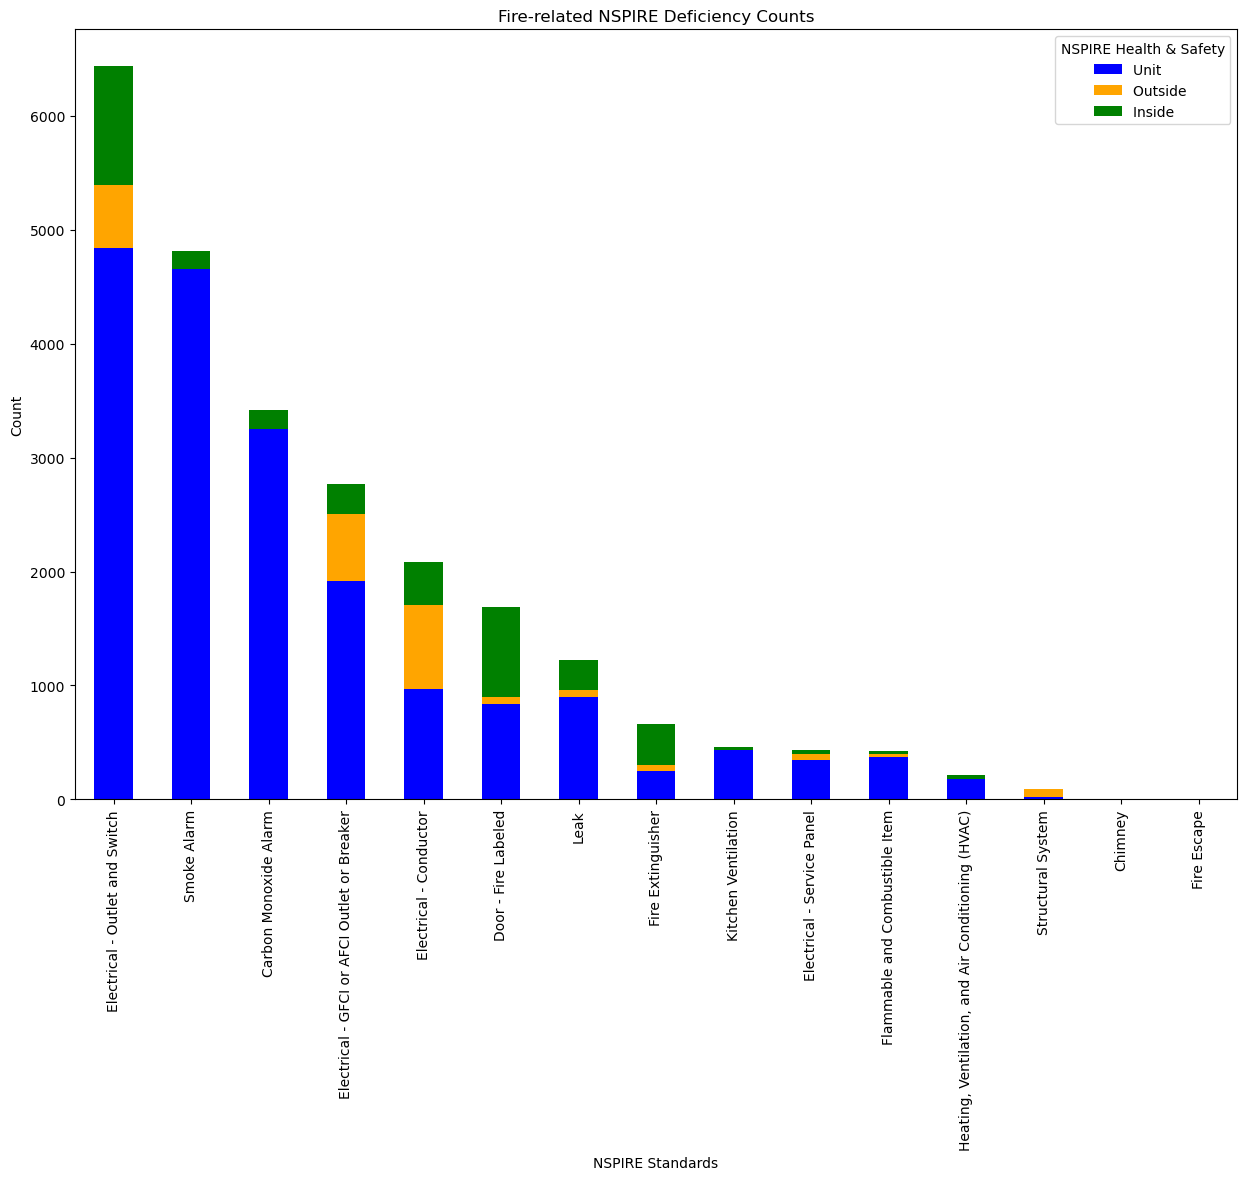

In [46]:
grouped = fire_related.groupby(['NSPIRE Standards', 'details1']).size()

df = grouped.reset_index()
df.columns = ['NSPIRE Standards', 'NSPIRE Health & Safety', 'count']

# Pivot your DataFrame
df_pivot = df.pivot(index='NSPIRE Standards', columns='NSPIRE Health & Safety', values='count')

colors = {'Inside ': 'Green', 'Unit ': 'Blue', 'Outside ': 'Orange'}

# Create a list of colors for each column
column_colors = [colors[col] for col in reversed(df_pivot.columns)]

# Reorder the DataFrame columns for stacking and bars for total count
df_pivot = df_pivot[reversed(df_pivot.columns)]
df_pivot = df_pivot.reindex(df_pivot.sum(axis=1).sort_values(ascending=False).index)

# Plotting
df_pivot.plot(kind='bar', stacked=True, color=column_colors, figsize=(15,10))
plt.title('Fire-related NSPIRE Deficiency Counts')
plt.xlabel('NSPIRE Standards')
plt.ylabel('Count')
plt.show()

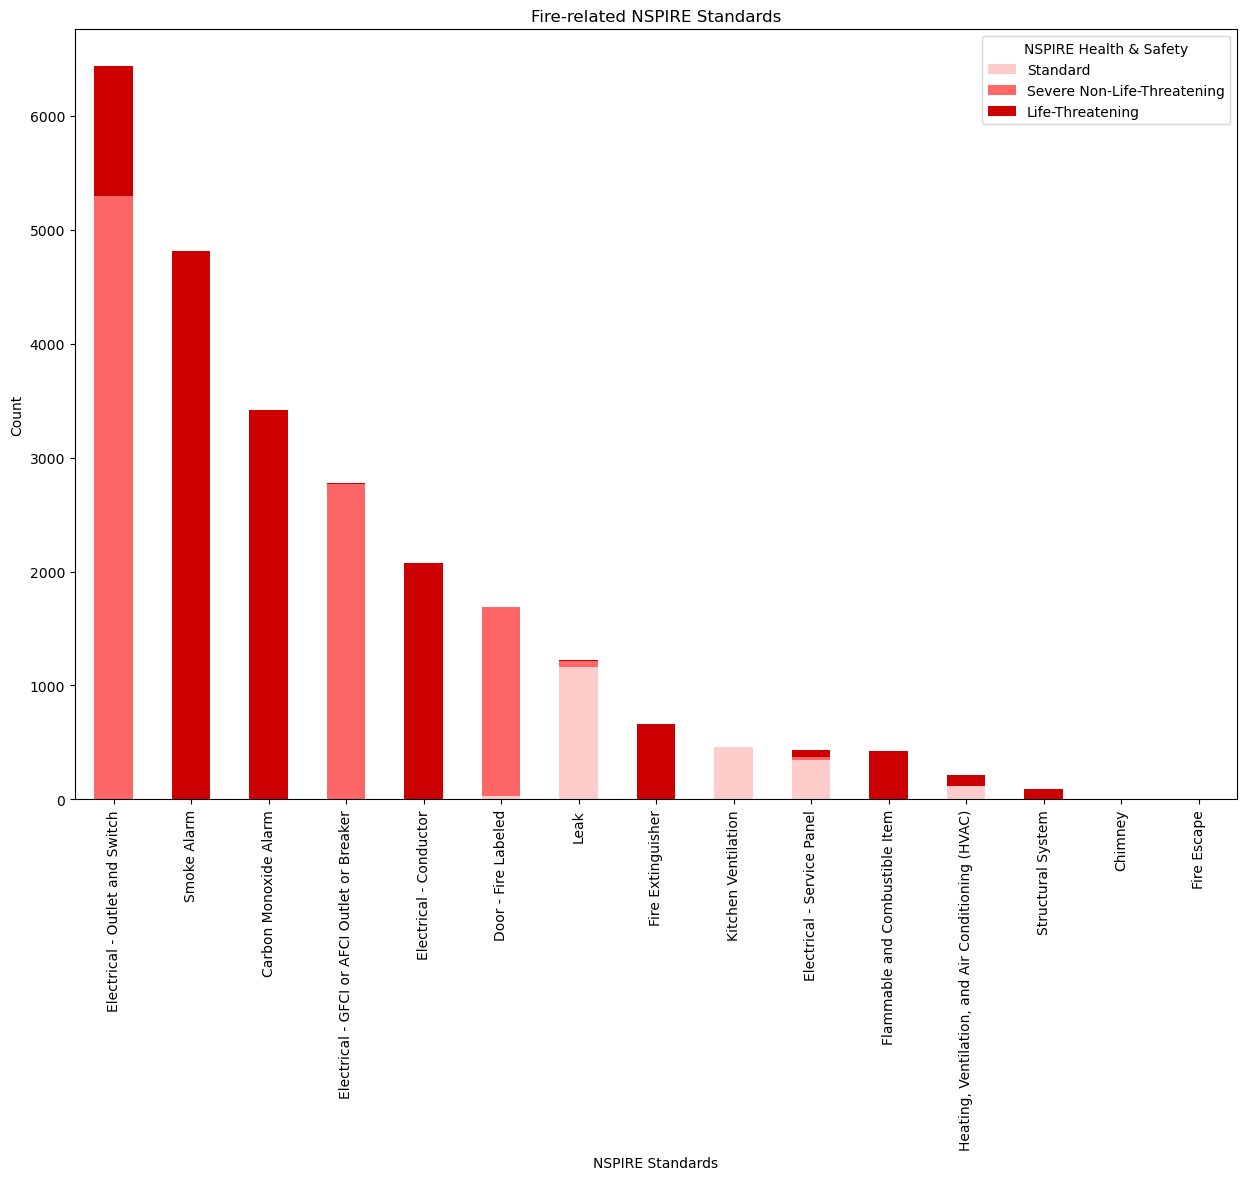

In [47]:
grouped = fire_related.groupby(['NSPIRE Standards', 'NSPIRE Health & Safety']).size()

df = grouped.reset_index()
df.columns = ['NSPIRE Standards', 'NSPIRE Health & Safety', 'count']

# Pivot your DataFrame
df_pivot = df.pivot(index='NSPIRE Standards', columns='NSPIRE Health & Safety', values='count')

# Define the color map with more contrast and reverse the order for stacking
colors = {'Standard': '#FFCCCC', 'Severe Non-Life-Threatening': '#FF6666', 'Life-Threatening': '#CC0000'}

# Create a list of colors for each column
column_colors = [colors[col] for col in reversed(df_pivot.columns)]

# Reorder the DataFrame columns for stacking and bars for total count
df_pivot = df_pivot[reversed(df_pivot.columns)]
df_pivot = df_pivot.reindex(df_pivot.sum(axis=1).sort_values(ascending=False).index)

# Plotting
df_pivot.plot(kind='bar', stacked=True, color=column_colors, figsize=(15,10))
plt.title('Fire-related NSPIRE Standards')
plt.xlabel('NSPIRE Standards')
plt.ylabel('Count')
plt.show()

# Fire related deficiencies by location

### Alarms as percent of all deficiencies by state

In [40]:
nspire.groupby(by='Shipping State/Province').size().sort_values()

Shipping State/Province
NM       4
ON      10
ND      33
OR      60
MT      60
IA     117
SD     155
UT     172
MN     192
VT     290
NV     312
AR     320
AZ     396
ME     409
WV     456
DE     478
KS     480
WA     583
NE     662
WI     939
IN    1011
CO    1112
OK    1217
NH    1258
RI    1424
GA    1520
MD    1537
SC    1825
TX    1856
OH    2002
TN    2038
KY    2108
VA    2122
IL    2317
MO    2341
LA    2466
MS    2472
NJ    2613
MI    2987
NC    3121
FL    3321
CT    3357
MA    3445
NY    4577
PA    5112
AL    5182
CA    6758
dtype: int64

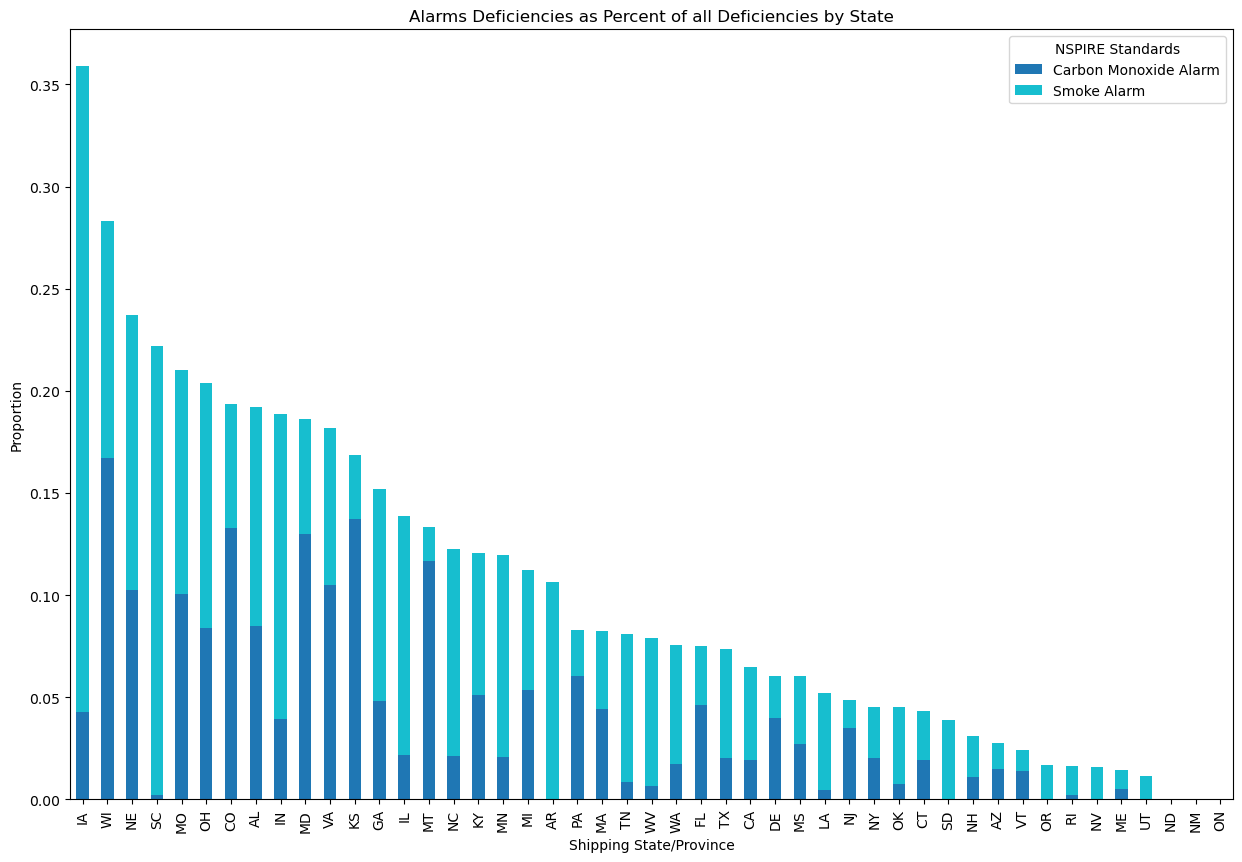

In [48]:
alarms = nspire[
    (nspire['NSPIRE Standards'] == 'Smoke Alarm') |
    (nspire['NSPIRE Standards'] == 'Carbon Monoxide Alarm')
]

# Select relevant data and group by 'Shipping State/Province' and 'NSPIRE Standards'
grouped_alarms = alarms.groupby(by=['Shipping State/Province', 'NSPIRE Standards']).size().reset_index()
grouped_alarms.columns = ['Shipping State/Province', 'NSPIRE Standards', 'count']

# Pivot the data
pivot_alarms = grouped_alarms.pivot(index='Shipping State/Province', columns='NSPIRE Standards', values='count')

# Fill NaN values with 0
pivot_alarms = pivot_alarms.fillna(0)

# Add a total column and sort by it
pivot_alarms['total'] = pivot_alarms.sum(axis=1)
pivot_alarms = pivot_alarms.sort_values('total', ascending=False)

# Remove the total column before plotting
del pivot_alarms['total']

# Calculate total alarm deficiencies for each state
total_alarm_deficiencies = pivot_alarms.sum(axis=1)

total_deficiencies = nspire.groupby(by='Shipping State/Province').size()

# Calculate proportion of alarm deficiencies to total deficiencies for each state
proportion_alarm_deficiencies = total_alarm_deficiencies / total_deficiencies

# Calculate the proportion of alarm deficiencies to total deficiencies
pivot_alarms_proportion = pivot_alarms.div(total_deficiencies, axis=0)

# Remove any NaN values (might occur if a state has no deficiencies at all)
pivot_alarms_proportion = pivot_alarms_proportion.fillna(0)

# Sort states by proportion of alarm deficiencies
pivot_alarms_proportion = pivot_alarms_proportion.loc[proportion_alarm_deficiencies.sort_values(ascending=False).index]

# Plot the data
pivot_alarms_proportion.plot(kind='bar', stacked=True, figsize=(15,10), cmap='tab10')
plt.title('Alarms Deficiencies as Percent of all Deficiencies by State')
plt.xlabel('Shipping State/Province')
plt.ylabel('Proportion')
plt.show()

### Alarms as percent of all deciciencies by city

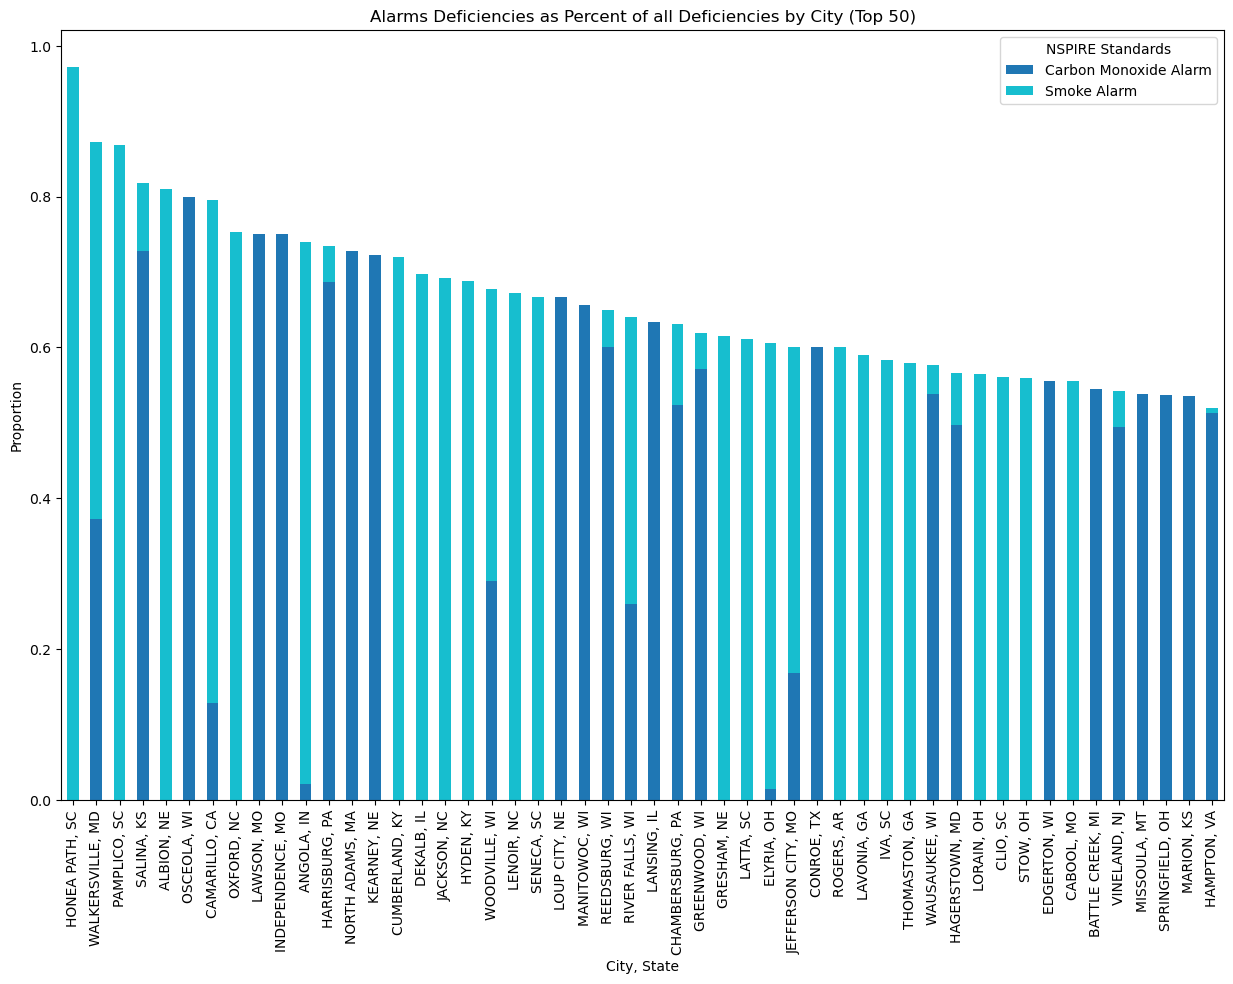

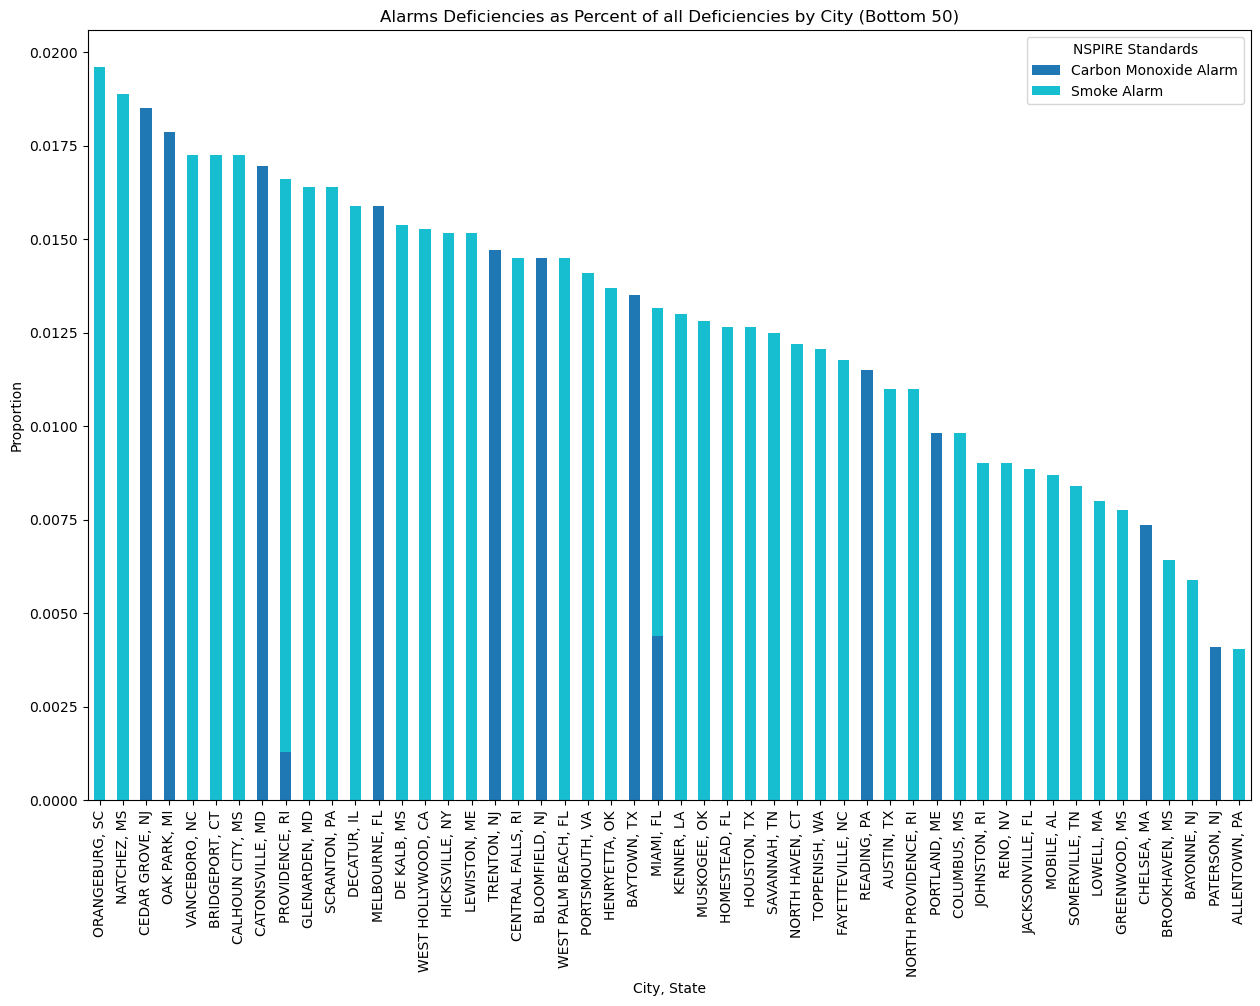

In [49]:
alarms = nspire[
    (nspire['NSPIRE Standards'] == 'Smoke Alarm') |
    (nspire['NSPIRE Standards'] == 'Carbon Monoxide Alarm')
]

# Select relevant data and group by 'Shipping City', 'Shipping State/Province', and 'NSPIRE Standards'
grouped_alarms = alarms.groupby(by=['Shipping City', 'Shipping State/Province', 'NSPIRE Standards']).size().reset_index()
grouped_alarms.columns = ['Shipping City', 'Shipping State/Province', 'NSPIRE Standards', 'count']

# Create a new 'City, State' column for clearer labeling in the plot
grouped_alarms['City, State'] = grouped_alarms['Shipping City'] + ', ' + grouped_alarms['Shipping State/Province']

# Pivot the data
pivot_alarms = grouped_alarms.pivot(index='City, State', columns='NSPIRE Standards', values='count')

# Fill NaN values with 0
pivot_alarms = pivot_alarms.fillna(0)

# Add a total column and sort by it
pivot_alarms['total'] = pivot_alarms.sum(axis=1)
pivot_alarms = pivot_alarms.sort_values('total', ascending=False)

# Remove the total column before plotting
del pivot_alarms['total']

# Calculate total alarm deficiencies for each city
total_alarm_deficiencies = pivot_alarms.sum(axis=1)

total_deficiencies = nspire.groupby(by=['Shipping City', 'Shipping State/Province']).size()
total_deficiencies.index = total_deficiencies.index.map(', '.join)

# Calculate proportion of alarm deficiencies to total deficiencies for each city
proportion_alarm_deficiencies = total_alarm_deficiencies / total_deficiencies

# Remove cities where the proportion is zero
proportion_alarm_deficiencies = proportion_alarm_deficiencies[proportion_alarm_deficiencies > 0]

# Calculate the proportion of alarm deficiencies to total deficiencies
pivot_alarms_proportion = pivot_alarms.div(total_deficiencies, axis=0)

# Remove any NaN values (might occur if a city has no deficiencies at all)
pivot_alarms_proportion = pivot_alarms_proportion.fillna(0)

# Sort cities by proportion of alarm deficiencies
pivot_alarms_proportion = pivot_alarms_proportion.loc[proportion_alarm_deficiencies.sort_values(ascending=False).index]

top_30_cities = pivot_alarms_proportion.iloc[:50]
bottom_30_cities = pivot_alarms_proportion.iloc[-50:]

top_30_cities.plot(kind='bar', stacked=True, figsize=(15,10), cmap='tab10')
plt.title('Alarms Deficiencies as Percent of all Deficiencies by City (Top 50)')
plt.xlabel('City, State')
plt.ylabel('Proportion')
plt.show()

bottom_30_cities.plot(kind='bar', stacked=True, figsize=(15,10), cmap='tab10')
plt.title('Alarms Deficiencies as Percent of all Deficiencies by City (Bottom 50)')
plt.xlabel('City, State')
plt.ylabel('Proportion')
plt.show()


This plot shows us the whole distribution of cities (we only display the tail ends above.)

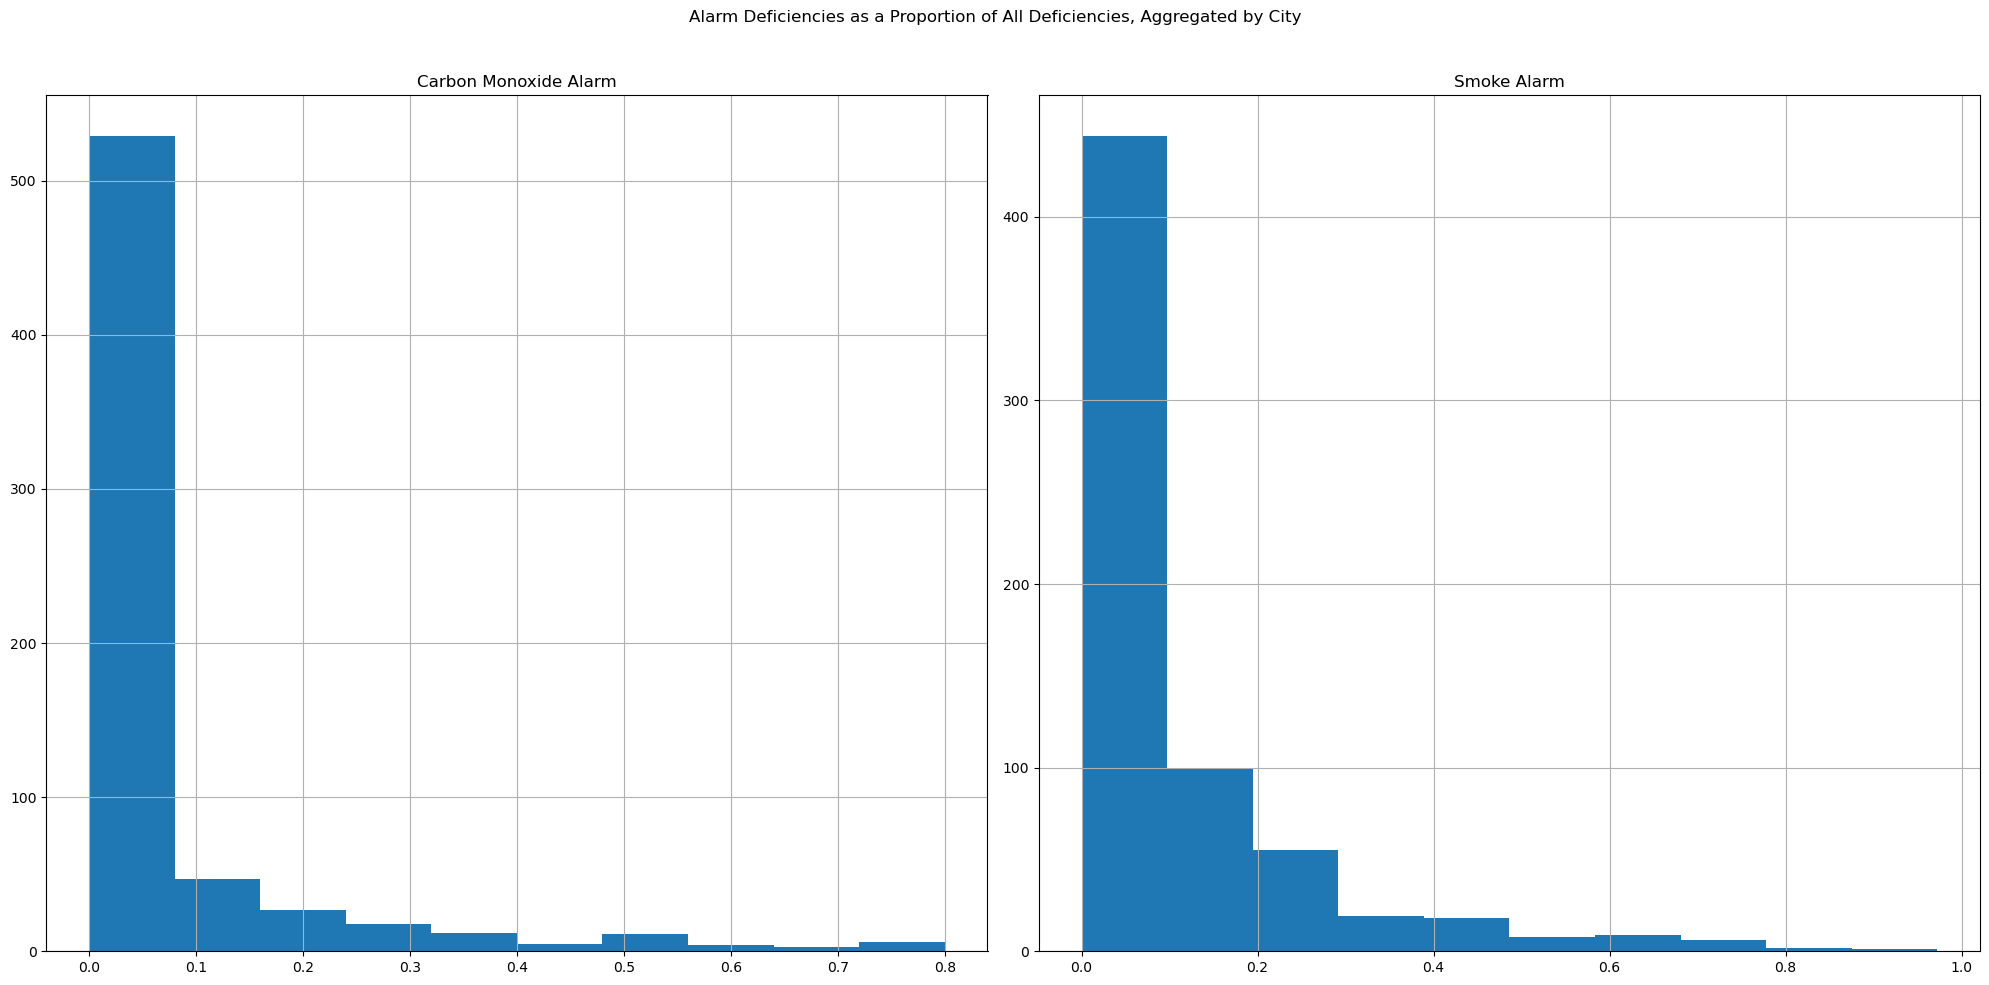

In [62]:
ax = pivot_alarms_proportion.hist(figsize=(20, 10))

# ax is a 2D array containing the axes for each subplot. 
# ax[0, 0] is the first one, so we can set the title on that.
ax[0, 0].figure.suptitle('Alarm Deficiencies as a Proportion of All Deficiencies, Aggregated by City')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust the layout so title doesn't overlap
plt.show()

### Electrical issues as percent of all deficiencies by state

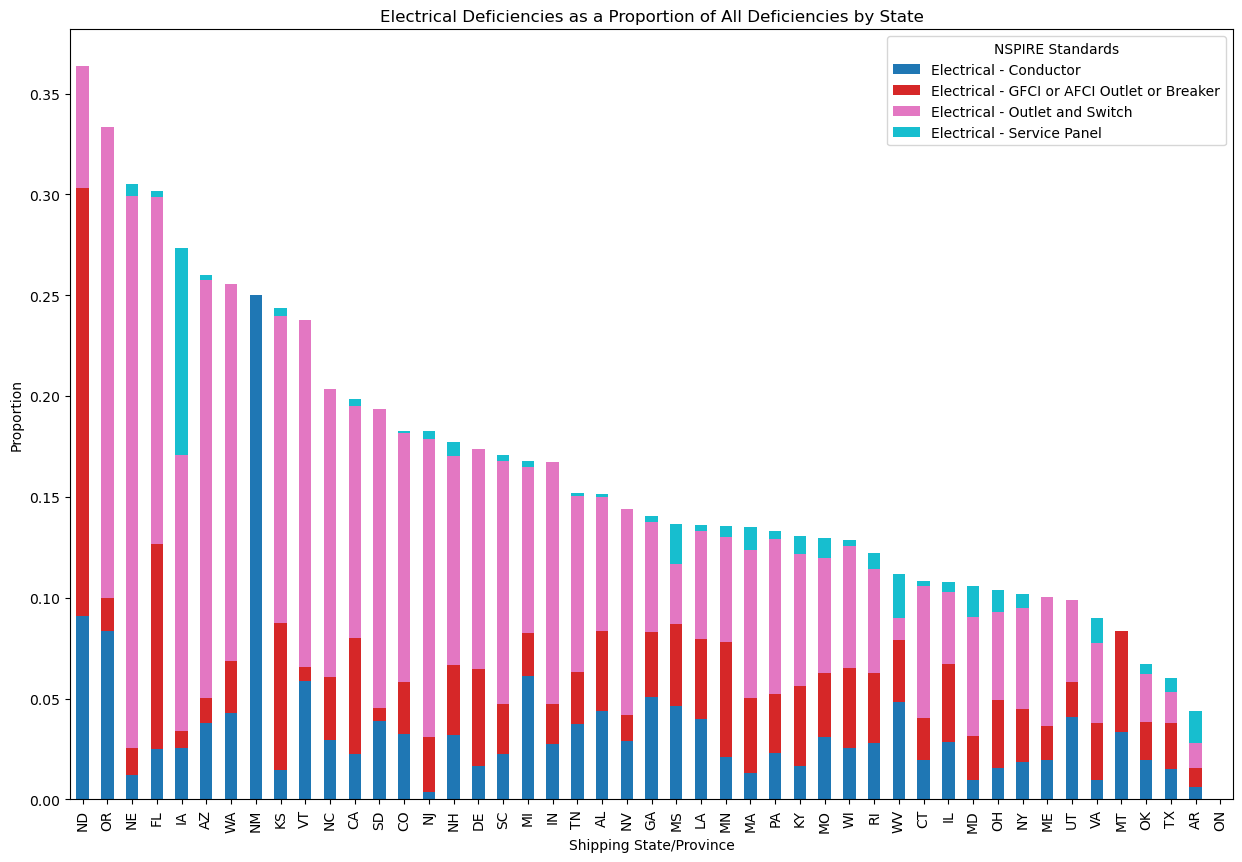

In [63]:
electric = nspire[
    (nspire['NSPIRE Standards'] == "Electrical - Outlet and Switch") |
    (nspire['NSPIRE Standards'] == "Electrical - Conductor") |
    (nspire['NSPIRE Standards'] == "Electrical - Service Panel") |
    (nspire['NSPIRE Standards'] == "Electrical - GFCI or AFCI Outlet or Breaker")
]

# Select relevant data and group by 'Shipping State/Province' and 'NSPIRE Standards'
grouped_electric = electric.groupby(by=['Shipping State/Province', 'NSPIRE Standards']).size().reset_index()
grouped_electric.columns = ['Shipping State/Province', 'NSPIRE Standards', 'count']

# Pivot the data
pivot_electric = grouped_electric.pivot(index='Shipping State/Province', columns='NSPIRE Standards', values='count')

# Fill NaN values with 0
pivot_electric = pivot_electric.fillna(0)

# Add a total column and sort by it
pivot_electric['total'] = pivot_electric.sum(axis=1)
pivot_electric = pivot_electric.sort_values('total', ascending=False)

# Remove the total column before plotting
del pivot_electric['total']

# Calculate total electric deficiencies for each state
total_electric_deficiencies = pivot_electric.sum(axis=1)

total_deficiencies = nspire.groupby(by='Shipping State/Province').size()

# Calculate proportion of electric deficiencies to total deficiencies for each state
proportion_electric_deficiencies = total_electric_deficiencies / total_deficiencies

# Calculate the proportion of electric deficiencies to total deficiencies
pivot_electric_proportion = pivot_electric.div(total_deficiencies, axis=0)

# Remove any NaN values (might occur if a state has no deficiencies at all)
pivot_electric_proportion = pivot_electric_proportion.fillna(0)

# Sort states by proportion of electric deficiencies
pivot_electric_proportion = pivot_electric_proportion.loc[proportion_electric_deficiencies.sort_values(ascending=False).index]

# Plot the data
pivot_electric_proportion.plot(kind='bar', stacked=True, figsize=(15,10), cmap='tab10')
plt.title('Electrical Deficiencies as a Proportion of All Deficiencies by State')
plt.xlabel('Shipping State/Province')
plt.ylabel('Proportion')
plt.show()


# Export

In [44]:
nspire.to_csv('../data/processed/nspire_partial_clean.csv', index=False, sep=',')